# Diffusion model

In this problem, you will be implementing some parts of the denoising diffusion probabilistic model. Specifically, you will need to implement the attention layer in the model architecture and the classifier-free guidance for sampling. Finally you'll be able to train a model that can generate images with Cifar-10 dataset. Have fun!

In [1]:
# Imports

from contextlib import contextmanager
from copy import deepcopy
from glob import glob
import math, os, random
from matplotlib.pyplot import imread # alternative to scipy.misc.imread
import matplotlib.patches as patches
import os.path
from os.path import *

from IPython import display
from matplotlib import pyplot as plt
import torch
from torch import optim, nn, Tensor
from torch.nn import functional as F
from torch.utils import data
from torchvision import datasets, transforms, utils
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm, trange


In [2]:
# Utilities

@contextmanager
def train_mode(model, mode=True):
    """A context manager that places a model into training mode and restores
    the previous mode on exit."""
    modes = [module.training for module in model.modules()]
    try:
        yield model.train(mode)
    finally:
        for i, module in enumerate(model.modules()):
            module.training = modes[i]


def eval_mode(model):
    """A context manager that places a model into evaluation mode and restores
    the previous mode on exit."""
    return train_mode(model, False)


@torch.no_grad()
def ema_update(model, averaged_model, decay):
    """Incorporates updated model parameters into an exponential moving averaged
    version of a model. It should be called after each optimizer step."""
    model_params = dict(model.named_parameters())
    averaged_params = dict(averaged_model.named_parameters())
    assert model_params.keys() == averaged_params.keys()

    for name, param in model_params.items():
        averaged_params[name].mul_(decay).add_(param, alpha=1 - decay)

    model_buffers = dict(model.named_buffers())
    averaged_buffers = dict(averaged_model.named_buffers())
    assert model_buffers.keys() == averaged_buffers.keys()

    for name, buf in model_buffers.items():
        averaged_buffers[name].copy_(buf)


In [3]:
class SelfAttention(nn.Module):
    def __init__(self, dim_in: int, dim_q: int, dim_v: int):
        super().__init__()

        """
        This class is used for calculating single head attention. 
        You will first initialize the layers, then implement 
        (QK^T / sqrt(d_k))V in function scaled_dot_product.
        Finally you'll need to put them all together into the forward funciton.
        
        args:
            dim_in: an int value for input sequence embedding dimension
            dim_q: an int value for output dimension of query and ley vector
            dim_v: an int value for output dimension for value vectors
        """
        self.q = None  # initialize for query
        self.k = None  # initialize for key
        self.v = None  # initialize for value
        ##########################################################################
        # TODO: This function initializes three linear layers to get Q, K, V.    #
        # Please use the same names for query, key and value transformations     #
        # as given above. self.q, self.k, and self.v respectively.               #
        ##########################################################################
        # Replace "pass" statement with your code

        self.q = nn.Linear(dim_in,dim_q)
        self.k = nn.Linear(dim_in,dim_q)
        self.v = nn.Linear(dim_in,dim_v)
      

        ##########################################################################
        #               END OF YOUR CODE                                         #
        ##########################################################################

    def scaled_dot_product(self,
        query: Tensor, key: Tensor, value: Tensor
    ) -> Tensor:
        """
        The function performs a fundamental block for attention mechanism, the scaled
        dot product. 
        args:
            query: a Tensor of shape (N,K, M) where N is the batch size, K is the
                sequence length and M is the sequence embeding dimension
            key:  a Tensor of shape (N, K, M) where N is the batch size, K is the
                sequence length and M is the sequence embeding dimension
            value: a Tensor of shape (N, K, M) where N is the batch size, K is the
                sequence length and M is the sequence embeding dimension
        return:
            y: a tensor of shape (N, K, M) that contains the weighted sum of values
        """

        y = None
        ###############################################################################
        # TODO: This function calculates (QK^T / sqrt(d_k))V on a batch scale.        #
        # Implement this function using no loops.                                     #
        ###############################################################################
        # Replace "pass" statement with your code
        # NKM times NMK
        output = torch.bmm(query,key.permute(0,2,1)) / math.sqrt(query.shape[2])
        output = torch.softmax(output, dim=-1)
        y = torch.bmm(output,value)

        ##############################################################################
        #               END OF YOUR CODE                                             #
        ##############################################################################
        return y

    def forward(
        self, query: Tensor, key: Tensor, value: Tensor
    ) -> Tensor:

        """
        An implementation of the forward pass of the self-attention layer.
        args:
            query: Tensor of shape (N, K, M)
            key: Tensor of shape (N, K, M)
            value: Tensor of shape (N, K, M)
        return:
            y: Tensor of shape (N, K, dim_v)
        """
        y = None
        ##########################################################################
        # TODO: Implement the forward pass of attention layer with functions     #
        # defined above.                                                         #
        ##########################################################################
        # Replace "pass" statement with your code
        
        y = self.scaled_dot_product(self.q(query),self.k(key),self.v(value))

        ##########################################################################
        #               END OF YOUR CODE                                         #
        ##########################################################################

        return y

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads: int, dim_in: int, dim_out: int, dropout_rate:float = 0.1):
        super().__init__()

        """
        
        A naive implementation of the MultiheadAttention layer. You will apply 
        the self attention defined above and concat them together to calculate
        multi-head attention.
        args:
            num_heads: int value specifying the number of heads
            dim_in: int value specifying the input dimension of the query, key
                and value. This will be the input dimension to each of the
                SingleHeadAttention blocks
            dim_out: int value specifying the output dimension of the complete 
                MultiHeadAttention block
        """

        ##########################################################################
        # TODO: Initialize two things here:                                      #
        # 1.) Use nn.ModuleList to initialze a list of SingleHeadAttention layer #
        # modules.The length of this list should be equal to num_heads with each #
        # SingleHeadAttention layer having input dimension as dim_in, and the    #
        # last dimension of concated heads should be d_out                       #
        # 2.) Use nn.Linear to map the output of nn.Modulelist block back to     #
        # dim_in.                                                                #
        ##########################################################################
        # Replace "pass" statement with your code
        self.linearMap = nn.Linear(dim_out,dim_in)
        self.attentionList = nn.ModuleList([SelfAttention(dim_in=dim_in, dim_q= dim_out // num_heads, dim_v= dim_out // num_heads) for i in range(num_heads)])

        ##########################################################################
        #               END OF YOUR CODE                                         #
        ##########################################################################

        self.dropout = nn.Dropout(dropout_rate)
        self.norm = nn.LayerNorm(dim_out)

    def forward(
        self, x: Tensor
    ) -> Tensor:

        """
        An implementation of the forward pass of the MultiHeadAttention layer.
        args:
            query: Tensor of shape (N, K, M) where N is the number of sequences in
                the batch, K is the sequence length and M is the input embedding
                dimension. M should be equal to dim_in in the init function
            key: Tensor of shape (N, K, M) where N is the number of sequences in
                the batch, K is the sequence length and M is the input embedding
                dimension. M should be equal to dim_in in the init function
            value: Tensor of shape (N, K, M) where N is the number of sequences in
                the batch, K is the sequence length and M is the input embedding
                dimension. M should be equal to dim_in in the init function
        returns:
            y: Tensor of shape (N, K, M)
        """
        y = None
        n, c, h, w = x.shape
        x = x.reshape(n, c, h*w).transpose(-2, -1)
        query, key, value = x, x, x
        ##########################################################################
        # TODO: Implement the forward pass of multi-head attention layer with    #
        # functions defined above.                                               #
        ##########################################################################
        # Replace "pass" statement with your code
        heads = torch.zeros((0,0,0),device='cuda')
        count = 1
        for layer in self.attentionList:
          if count==1:
            heads = layer(query,key,value)
          else:
            temp = layer(query,key,value) # (N, K, dim_v)
            heads = torch.cat((heads, temp), dim=-1)
          count = count + 1
        
        y = self.linearMap(heads)
        
        ##########################################################################
        #               END OF YOUR CODE                                         #
        ##########################################################################

        # Residual connection, normalization and dropout
        return self.dropout(self.norm(x) + y).transpose(-2, -1).reshape(n, c, h, w)

In [4]:
# Define the model (a residual U-Net)

class ResidualBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return self.main(input) + self.skip(input)


class ResConvBlock(ResidualBlock):
    def __init__(self, c_in, c_mid, c_out, is_last=False):
        skip = None if c_in == c_out else nn.Conv2d(c_in, c_out, 1, bias=False)
        super().__init__([
            nn.Conv2d(c_in, c_mid, 3, padding=1),
            nn.Dropout2d(0.1, inplace=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(c_mid, c_out, 3, padding=1),
            nn.Dropout2d(0.1, inplace=True) if not is_last else nn.Identity(),
            nn.ReLU(inplace=True) if not is_last else nn.Identity(),
        ], skip)

class SkipBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return torch.cat([self.main(input), self.skip(input)], dim=1)


class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, std=1.):
        super().__init__()
        assert out_features % 2 == 0
        self.weight = nn.Parameter(torch.randn([out_features // 2, in_features]) * std)

    def forward(self, input):
        f = 2 * math.pi * input @ self.weight.T
        return torch.cat([f.cos(), f.sin()], dim=-1)


def expand_to_planes(input, shape):
    return input[..., None, None].repeat([1, 1, shape[2], shape[3]])


class Diffusion(nn.Module):
    def __init__(self):
        super().__init__()
        c = 64  # The base channel count

        self.timestep_embed = FourierFeatures(1, 16)
        self.class_embed = nn.Embedding(11, 4)

        self.net = nn.Sequential(   # 32x32
            ResConvBlock(3 + 16 + 4, c, c),
            ResConvBlock(c, c, c),
            SkipBlock([
                nn.AvgPool2d(2),  # 32x32 -> 16x16
                ResConvBlock(c, c * 2, c * 2),
                ResConvBlock(c * 2, c * 2, c * 2),
                SkipBlock([
                    nn.AvgPool2d(2),  # 16x16 -> 8x8
                    ResConvBlock(c * 2, c * 4, c * 4),
                    MultiHeadAttention(c * 4 // 64, c * 4, c * 4),
                    ResConvBlock(c * 4, c * 4, c * 4),
                    MultiHeadAttention(c * 4 // 64, c * 4, c * 4),
                    SkipBlock([
                        nn.AvgPool2d(2),  # 8x8 -> 4x4
                        ResConvBlock(c * 4, c * 8, c * 8),
                        MultiHeadAttention(c * 8 // 64, c * 8, c * 8),
                        ResConvBlock(c * 8, c * 8, c * 8),
                        MultiHeadAttention(c * 8 // 64, c * 8, c * 8),
                        ResConvBlock(c * 8, c * 8, c * 8),
                        MultiHeadAttention(c * 8 // 64, c * 8, c * 8),
                        ResConvBlock(c * 8, c * 8, c * 4),
                        MultiHeadAttention(c * 4 // 64, c * 4, c * 4),
                        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                    ]),  # 4x4 -> 8x8
                    ResConvBlock(c * 8, c * 4, c * 4),
                    MultiHeadAttention(c * 4 // 64, c * 4, c * 4),
                    ResConvBlock(c * 4, c * 4, c * 2),
                    MultiHeadAttention(c * 2 // 64, c * 2, c * 2),
                    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                ]),  # 8x8 -> 16x16
                ResConvBlock(c * 4, c * 2, c * 2),
                ResConvBlock(c * 2, c * 2, c),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            ]),  # 16x16 -> 32x32
            ResConvBlock(c * 2, c, c),
            ResConvBlock(c, c, 3, is_last=True),
        )

    def forward(self, input, t, cond):
        timestep_embed = expand_to_planes(self.timestep_embed(t[:, None]), input.shape)
        class_embed = expand_to_planes(self.class_embed(cond + 1), input.shape)
        return self.net(torch.cat([input, class_embed, timestep_embed], dim=1))


## TODO: (b) implement sampling process of diffusion model

In this problem, you will perform classifier-free guidance for sampling.

In [5]:
# Define the noise schedule and sampling loop

def get_alphas_sigmas(t):
    """Returns the scaling factors for the clean image (alpha) and for the
    noise (sigma), given a timestep."""
    return torch.cos(t * math.pi / 2), torch.sin(t * math.pi / 2)


@torch.no_grad()
def sample(model, x, steps, eta, classes, guidance_scale=1.):
    """Draws samples from a model given starting noise."""
    ts = x.new_ones([x.shape[0]])

    # Create the noise schedule
    t = torch.linspace(1, 0, steps + 1)[:-1]
    alphas, sigmas = get_alphas_sigmas(t)

    # The sampling loop
    for i in trange(steps):

        # Get the model output (v, the predicted velocity)
        ##########################################################################
        # TODO: Perform classifier-free guidance:
                                        
        # 1.) Generate inputs for both conditional images and unconditional      #
        # images given their class.                                              #
        # Hint: To generate unconditional input, copy the input images and time  #
        # stamps and stack them with the original input images and time stamps.  #
        # The only thing you need to change is the create the unconditional      #
        # class "-1" and stack it with the input conditional class. Thus You     #
        # will have a tensor of twice of the batch size of the original input. 
          
        # 2.) Pass your stacked input to the model to get both conditional and   #
        # unconditional vecocity.  
                                                      
        # 3.) Compute v = v_uncond + guidance_scale * (v_cond - v_uncond)        #
        ##########################################################################
        # Replace "pass" statement with your code
        
        #print(x.shape)
        #print(t.shape)
        #print(classes.shape)
        z = torch.cat((x,x), dim=0).cuda()
        z_class = torch.cat((classes, -1*torch.ones_like(classes)), dim=0).cuda()
        z_time = torch.cat((t[i]*torch.ones_like(classes), t[i]*torch.ones_like(classes)), dim=0).cuda()
        #print(z.shape)
        #print(z_time.shape)
        #print(z_class.shape)
        
        output = model(z,z_time,z_class)
        v_cond, v_uncond = torch.chunk(output, 2, dim=0)

        v = v_uncond + guidance_scale*(v_cond - v_uncond)

        ##########################################################################
        #               END OF YOUR CODE                                         #
        ##########################################################################

        # Predict the noise and the denoised image
        pred = x * alphas[i] - v * sigmas[i]
        eps = x * sigmas[i] + v * alphas[i]

        # If we are not on the last timestep, compute the noisy image for the
        # next timestep.
        if i < steps - 1:
            # If eta > 0, adjust the scaling factor for the predicted noise
            # downward according to the amount of additional noise to add
            ddim_sigma = eta * (sigmas[i + 1]**2 / sigmas[i]**2).sqrt() * \
                (1 - alphas[i]**2 / alphas[i + 1]**2).sqrt()
            adjusted_sigma = (sigmas[i + 1]**2 - ddim_sigma**2).sqrt()

            # Recombine the predicted noise and predicted denoised image in the
            # correct proportions for the next step
            x = pred * alphas[i + 1] + eps * adjusted_sigma

            # Add the correct amount of fresh noise
            if eta:
                x += torch.randn_like(x) * ddim_sigma

    # If we are on the last timestep, output the denoised image
    return pred


The noise schedule:


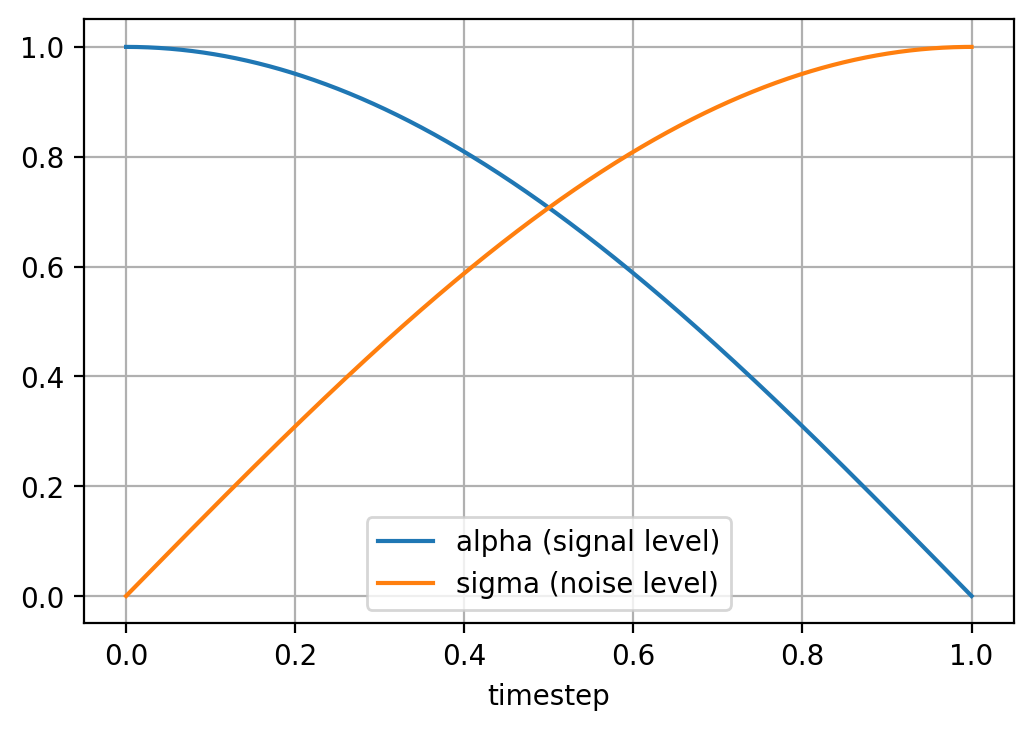

In [6]:
# Visualize the noise schedule

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 100

t_vis = torch.linspace(0, 1, 1000)
alphas_vis, sigmas_vis = get_alphas_sigmas(t_vis)

print('The noise schedule:')

plt.plot(t_vis, alphas_vis, label='alpha (signal level)')
plt.plot(t_vis, sigmas_vis, label='sigma (noise level)')
plt.legend()
plt.xlabel('timestep')
plt.grid()
plt.show()


In [7]:
# Prepare the dataset

batch_size = 100

tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])
train_set = datasets.CIFAR10('data', train=True, download=True, transform=tf)
train_dl = data.DataLoader(train_set, batch_size, shuffle=True,
                           num_workers=1, persistent_workers=True, pin_memory=True)
val_set = datasets.CIFAR10('data', train=False, download=True, transform=tf)
val_dl = data.DataLoader(val_set, batch_size,
                         num_workers=1, persistent_workers=True, pin_memory=True)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [8]:
# Create the model and optimizer

seed = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.manual_seed(0)

model = Diffusion().to(device)
model_ema = deepcopy(model)
print('Model parameters:', sum(p.numel() for p in model.parameters()))

opt = optim.Adam(model.parameters(), lr=2e-4)
scaler = torch.cuda.amp.GradScaler()
epoch = 0

# Use a low discrepancy quasi-random sequence to sample uniformly distributed
# timesteps. This considerably reduces the between-batch variance of the loss.
rng = torch.quasirandom.SobolEngine(1, scramble=True)

Using device: cuda
Model parameters: 27487287


As a sanity check, the total number of parameters in your model should match the following.

Model parameters: 27487287

Initial noise

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 0, loss: 0.659573

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

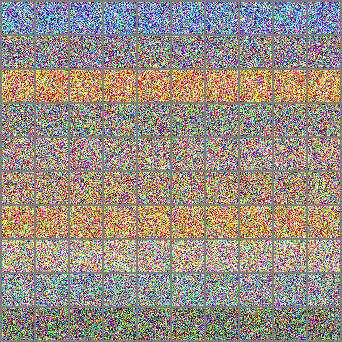


Epoch 0


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 0, iteration: 0, loss: 0.651582
Epoch: 0, iteration: 50, loss: 0.332843
Epoch: 0, iteration: 100, loss: 0.217117
Epoch: 0, iteration: 150, loss: 0.199165
Epoch: 0, iteration: 200, loss: 0.194742
Epoch: 0, iteration: 250, loss: 0.182038
Epoch: 0, iteration: 300, loss: 0.18094
Epoch: 0, iteration: 350, loss: 0.18694
Epoch: 0, iteration: 400, loss: 0.176955
Epoch: 0, iteration: 450, loss: 0.177187

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 0, loss: 0.156553

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

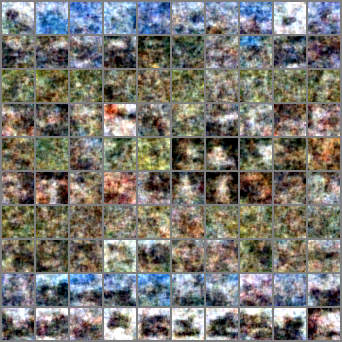


Epoch 1


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 1, iteration: 0, loss: 0.161872
Epoch: 1, iteration: 50, loss: 0.171297
Epoch: 1, iteration: 100, loss: 0.160897
Epoch: 1, iteration: 150, loss: 0.165521
Epoch: 1, iteration: 200, loss: 0.170159
Epoch: 1, iteration: 250, loss: 0.156866
Epoch: 1, iteration: 300, loss: 0.158521
Epoch: 1, iteration: 350, loss: 0.146488
Epoch: 1, iteration: 400, loss: 0.153386
Epoch: 1, iteration: 450, loss: 0.155603
Epoch 2


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 2, iteration: 0, loss: 0.140036
Epoch: 2, iteration: 50, loss: 0.155009
Epoch: 2, iteration: 100, loss: 0.156991
Epoch: 2, iteration: 150, loss: 0.1518
Epoch: 2, iteration: 200, loss: 0.145272
Epoch: 2, iteration: 250, loss: 0.150071
Epoch: 2, iteration: 300, loss: 0.135371
Epoch: 2, iteration: 350, loss: 0.153224
Epoch: 2, iteration: 400, loss: 0.144792
Epoch: 2, iteration: 450, loss: 0.145422
Epoch 3


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 3, iteration: 0, loss: 0.144276
Epoch: 3, iteration: 50, loss: 0.150701
Epoch: 3, iteration: 100, loss: 0.137814
Epoch: 3, iteration: 150, loss: 0.135317
Epoch: 3, iteration: 200, loss: 0.130542
Epoch: 3, iteration: 250, loss: 0.140396
Epoch: 3, iteration: 300, loss: 0.135144
Epoch: 3, iteration: 350, loss: 0.15488
Epoch: 3, iteration: 400, loss: 0.141263
Epoch: 3, iteration: 450, loss: 0.148619
Epoch 4


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 4, iteration: 0, loss: 0.137663
Epoch: 4, iteration: 50, loss: 0.13301
Epoch: 4, iteration: 100, loss: 0.141802
Epoch: 4, iteration: 150, loss: 0.144013
Epoch: 4, iteration: 200, loss: 0.136633
Epoch: 4, iteration: 250, loss: 0.141837
Epoch: 4, iteration: 300, loss: 0.155173
Epoch: 4, iteration: 350, loss: 0.140223
Epoch: 4, iteration: 400, loss: 0.139733
Epoch: 4, iteration: 450, loss: 0.125754
Epoch 5


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 5, iteration: 0, loss: 0.131556
Epoch: 5, iteration: 50, loss: 0.131902
Epoch: 5, iteration: 100, loss: 0.129277
Epoch: 5, iteration: 150, loss: 0.148592
Epoch: 5, iteration: 200, loss: 0.143967
Epoch: 5, iteration: 250, loss: 0.136355
Epoch: 5, iteration: 300, loss: 0.124331
Epoch: 5, iteration: 350, loss: 0.136628
Epoch: 5, iteration: 400, loss: 0.134302
Epoch: 5, iteration: 450, loss: 0.145535

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 5, loss: 0.12703

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

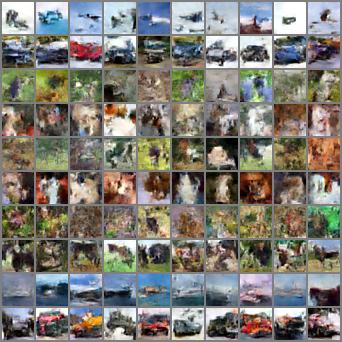


Epoch 6


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 6, iteration: 0, loss: 0.134856
Epoch: 6, iteration: 50, loss: 0.135705
Epoch: 6, iteration: 100, loss: 0.131178
Epoch: 6, iteration: 150, loss: 0.140955
Epoch: 6, iteration: 200, loss: 0.118933
Epoch: 6, iteration: 250, loss: 0.124761
Epoch: 6, iteration: 300, loss: 0.120303
Epoch: 6, iteration: 350, loss: 0.131072
Epoch: 6, iteration: 400, loss: 0.143108
Epoch: 6, iteration: 450, loss: 0.128755
Epoch 7


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 7, iteration: 0, loss: 0.143316
Epoch: 7, iteration: 50, loss: 0.146673
Epoch: 7, iteration: 100, loss: 0.136365
Epoch: 7, iteration: 150, loss: 0.127349
Epoch: 7, iteration: 200, loss: 0.132875
Epoch: 7, iteration: 250, loss: 0.127841
Epoch: 7, iteration: 300, loss: 0.132054
Epoch: 7, iteration: 350, loss: 0.131102
Epoch: 7, iteration: 400, loss: 0.135398
Epoch: 7, iteration: 450, loss: 0.141991
Epoch 8


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 8, iteration: 0, loss: 0.127125
Epoch: 8, iteration: 50, loss: 0.130177
Epoch: 8, iteration: 100, loss: 0.121372
Epoch: 8, iteration: 150, loss: 0.12809
Epoch: 8, iteration: 200, loss: 0.122419
Epoch: 8, iteration: 250, loss: 0.13347
Epoch: 8, iteration: 300, loss: 0.127105
Epoch: 8, iteration: 350, loss: 0.143767
Epoch: 8, iteration: 400, loss: 0.130068
Epoch: 8, iteration: 450, loss: 0.130407
Epoch 9


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 9, iteration: 0, loss: 0.122439
Epoch: 9, iteration: 50, loss: 0.134249
Epoch: 9, iteration: 100, loss: 0.126405
Epoch: 9, iteration: 150, loss: 0.143927
Epoch: 9, iteration: 200, loss: 0.127004
Epoch: 9, iteration: 250, loss: 0.141481
Epoch: 9, iteration: 300, loss: 0.130491
Epoch: 9, iteration: 350, loss: 0.113528
Epoch: 9, iteration: 400, loss: 0.12173
Epoch: 9, iteration: 450, loss: 0.136158
Epoch 10


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 10, iteration: 0, loss: 0.120233
Epoch: 10, iteration: 50, loss: 0.126944
Epoch: 10, iteration: 100, loss: 0.140046
Epoch: 10, iteration: 150, loss: 0.12829
Epoch: 10, iteration: 200, loss: 0.139348
Epoch: 10, iteration: 250, loss: 0.128343
Epoch: 10, iteration: 300, loss: 0.130207
Epoch: 10, iteration: 350, loss: 0.130892
Epoch: 10, iteration: 400, loss: 0.127476
Epoch: 10, iteration: 450, loss: 0.132228

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 10, loss: 0.122567

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

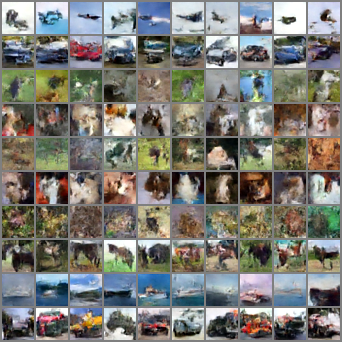


Epoch 11


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 11, iteration: 0, loss: 0.130918
Epoch: 11, iteration: 50, loss: 0.120101
Epoch: 11, iteration: 100, loss: 0.133638
Epoch: 11, iteration: 150, loss: 0.132251
Epoch: 11, iteration: 200, loss: 0.121675
Epoch: 11, iteration: 250, loss: 0.127211
Epoch: 11, iteration: 300, loss: 0.117109
Epoch: 11, iteration: 350, loss: 0.139316
Epoch: 11, iteration: 400, loss: 0.129785
Epoch: 11, iteration: 450, loss: 0.133046
Epoch 12


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 12, iteration: 0, loss: 0.123713
Epoch: 12, iteration: 50, loss: 0.136635
Epoch: 12, iteration: 100, loss: 0.118676
Epoch: 12, iteration: 150, loss: 0.129554
Epoch: 12, iteration: 200, loss: 0.134306
Epoch: 12, iteration: 250, loss: 0.128326
Epoch: 12, iteration: 300, loss: 0.130398
Epoch: 12, iteration: 350, loss: 0.136631
Epoch: 12, iteration: 400, loss: 0.124065
Epoch: 12, iteration: 450, loss: 0.124857
Epoch 13


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 13, iteration: 0, loss: 0.124613
Epoch: 13, iteration: 50, loss: 0.126895
Epoch: 13, iteration: 100, loss: 0.131537
Epoch: 13, iteration: 150, loss: 0.122238
Epoch: 13, iteration: 200, loss: 0.126169
Epoch: 13, iteration: 250, loss: 0.135098
Epoch: 13, iteration: 300, loss: 0.133218
Epoch: 13, iteration: 350, loss: 0.122649
Epoch: 13, iteration: 400, loss: 0.120709
Epoch: 13, iteration: 450, loss: 0.126857
Epoch 14


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 14, iteration: 0, loss: 0.131384
Epoch: 14, iteration: 50, loss: 0.1297
Epoch: 14, iteration: 100, loss: 0.131168
Epoch: 14, iteration: 150, loss: 0.132369
Epoch: 14, iteration: 200, loss: 0.12907
Epoch: 14, iteration: 250, loss: 0.125245
Epoch: 14, iteration: 300, loss: 0.120541
Epoch: 14, iteration: 350, loss: 0.123597
Epoch: 14, iteration: 400, loss: 0.134166
Epoch: 14, iteration: 450, loss: 0.136715
Epoch 15


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 15, iteration: 0, loss: 0.128904
Epoch: 15, iteration: 50, loss: 0.126215
Epoch: 15, iteration: 100, loss: 0.121267
Epoch: 15, iteration: 150, loss: 0.118806
Epoch: 15, iteration: 200, loss: 0.126374
Epoch: 15, iteration: 250, loss: 0.139649
Epoch: 15, iteration: 300, loss: 0.12294
Epoch: 15, iteration: 350, loss: 0.131118
Epoch: 15, iteration: 400, loss: 0.127799
Epoch: 15, iteration: 450, loss: 0.13431

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 15, loss: 0.119779

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

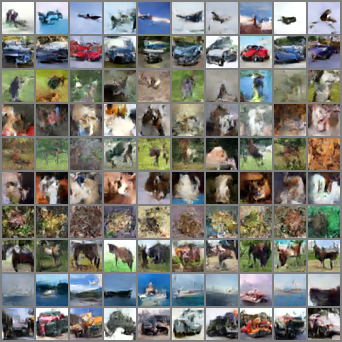


Epoch 16


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 16, iteration: 0, loss: 0.125729
Epoch: 16, iteration: 50, loss: 0.118473
Epoch: 16, iteration: 100, loss: 0.126334
Epoch: 16, iteration: 150, loss: 0.130862
Epoch: 16, iteration: 200, loss: 0.127835
Epoch: 16, iteration: 250, loss: 0.126139
Epoch: 16, iteration: 300, loss: 0.133577
Epoch: 16, iteration: 350, loss: 0.127716
Epoch: 16, iteration: 400, loss: 0.124571
Epoch: 16, iteration: 450, loss: 0.128462
Epoch 17


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 17, iteration: 0, loss: 0.133177
Epoch: 17, iteration: 50, loss: 0.122615
Epoch: 17, iteration: 100, loss: 0.128418
Epoch: 17, iteration: 150, loss: 0.126071
Epoch: 17, iteration: 200, loss: 0.137689
Epoch: 17, iteration: 250, loss: 0.12635
Epoch: 17, iteration: 300, loss: 0.124098
Epoch: 17, iteration: 350, loss: 0.11554
Epoch: 17, iteration: 400, loss: 0.12735
Epoch: 17, iteration: 450, loss: 0.132917
Epoch 18


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 18, iteration: 0, loss: 0.118042
Epoch: 18, iteration: 50, loss: 0.130607
Epoch: 18, iteration: 100, loss: 0.130764
Epoch: 18, iteration: 150, loss: 0.141313
Epoch: 18, iteration: 200, loss: 0.115767
Epoch: 18, iteration: 250, loss: 0.117925
Epoch: 18, iteration: 300, loss: 0.118179
Epoch: 18, iteration: 350, loss: 0.127093
Epoch: 18, iteration: 400, loss: 0.12852
Epoch: 18, iteration: 450, loss: 0.138892
Epoch 19


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 19, iteration: 0, loss: 0.134342
Epoch: 19, iteration: 50, loss: 0.126142
Epoch: 19, iteration: 100, loss: 0.11547
Epoch: 19, iteration: 150, loss: 0.112161
Epoch: 19, iteration: 200, loss: 0.129683
Epoch: 19, iteration: 250, loss: 0.122645
Epoch: 19, iteration: 300, loss: 0.131664
Epoch: 19, iteration: 350, loss: 0.134281
Epoch: 19, iteration: 400, loss: 0.125884
Epoch: 19, iteration: 450, loss: 0.131864
Epoch 20


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 20, iteration: 0, loss: 0.126991
Epoch: 20, iteration: 50, loss: 0.117396
Epoch: 20, iteration: 100, loss: 0.124519
Epoch: 20, iteration: 150, loss: 0.124897
Epoch: 20, iteration: 200, loss: 0.131115
Epoch: 20, iteration: 250, loss: 0.12099
Epoch: 20, iteration: 300, loss: 0.134515
Epoch: 20, iteration: 350, loss: 0.118051
Epoch: 20, iteration: 400, loss: 0.123112
Epoch: 20, iteration: 450, loss: 0.121092

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 20, loss: 0.118257

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

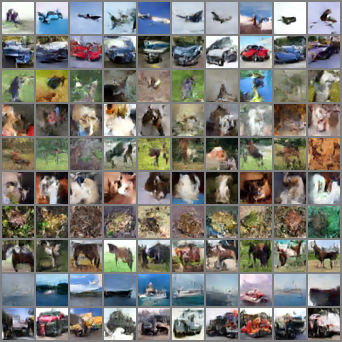

In [9]:
# Actually train the model

ema_decay = 0.999

# The number of timesteps to use when sampling
steps = 500

# The amount of noise to add each timestep when sampling
# 0 = no noise (DDIM)
# 1 = full noise (DDPM)
eta = 1.

# Classifier-free guidance scale (0 is unconditional, 1 is conditional)
guidance_scale = 2.

def eval_loss(model, rng, reals, classes):
    # Draw uniformly distributed continuous timesteps
    t = rng.draw(reals.shape[0])[:, 0].to(device)

    # Calculate the noise schedule parameters for those timesteps
    alphas, sigmas = get_alphas_sigmas(t)

    # Combine the ground truth images and the noise
    alphas = alphas[:, None, None, None]
    sigmas = sigmas[:, None, None, None]
    noise = torch.randn_like(reals)
    noised_reals = reals * alphas + noise * sigmas
    targets = noise * alphas - reals * sigmas

    # Drop out the class on 20% of the examples
    to_drop = torch.rand(classes.shape, device=classes.device).le(0.2)
    classes_drop = torch.where(to_drop, -torch.ones_like(classes), classes)

    # Compute the model output and the loss.
    #print(noised_reals.shape)
    #print(t.shape)
    #print(classes_drop.shape)


    v = model(noised_reals, t, classes_drop)
    return F.mse_loss(v, targets)


def train():
    for i, (reals, classes) in enumerate(tqdm(train_dl)):
        opt.zero_grad()
        reals = reals.to(device)
        classes = classes.to(device)

        # Evaluate the loss
        loss = eval_loss(model, rng, reals, classes)

        # Do the optimizer step and EMA update
        scaler.scale(loss).backward()
        scaler.step(opt)
        ema_update(model, model_ema, 0.95 if epoch < 5 else ema_decay)
        scaler.update()

        if i % 50 == 0:
            tqdm.write(f'Epoch: {epoch}, iteration: {i}, loss: {loss.item():g}')


@torch.no_grad()
@torch.random.fork_rng()
@eval_mode(model_ema)
def val():
    tqdm.write('\nValidating...')
    torch.manual_seed(seed)
    rng = torch.quasirandom.SobolEngine(1, scramble=True)
    total_loss = 0
    count = 0
    for i, (reals, classes) in enumerate(tqdm(val_dl)):
        reals = reals.to(device)
        classes = classes.to(device)

        loss = eval_loss(model_ema, rng, reals, classes)

        total_loss += loss.item() * len(reals)
        count += len(reals)
    loss = total_loss / count
    tqdm.write(f'Validation: Epoch: {epoch}, loss: {loss:g}')


@torch.no_grad()
@torch.random.fork_rng()
@eval_mode(model_ema)
def demo():
    tqdm.write('\nSampling...')
    torch.manual_seed(seed)

    noise = torch.randn([100, 3, 32, 32], device=device)
    fakes_classes = torch.arange(10, device=device).repeat_interleave(10, 0)
    fakes = sample(model_ema, noise, steps, eta, fakes_classes, guidance_scale)

    grid = utils.make_grid(fakes, 10).cpu()
    filename = f'demo_{epoch:05}.png'
    TF.to_pil_image(grid.add(1).div(2).clamp(0, 1)).save(filename)
    display.display(display.Image(filename))
    tqdm.write('')

# Each epoch might take up to 2.5 minutes
print("Initial noise")
val()
demo()
while epoch <= 20:
    print('Epoch', epoch)
    train()
    if epoch % 5 == 0:
        val()
        demo()
    epoch += 1


# Epipolar Geometry

Download the temple stereo images from the Middlebury stereo dataset.

In [10]:
!wget https://vision.middlebury.edu/mview/data/data/templeSparseRing.zip
!unzip templeSparseRing.zip

--2022-12-02 21:19:30--  https://vision.middlebury.edu/mview/data/data/templeSparseRing.zip
Resolving vision.middlebury.edu (vision.middlebury.edu)... 140.233.20.14
Connecting to vision.middlebury.edu (vision.middlebury.edu)|140.233.20.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4004383 (3.8M) [application/zip]
Saving to: ‘templeSparseRing.zip’

templeSparseRing.zi 100%[===================>]   3.82M  5.32MB/s    in 0.7s    

2022-12-02 21:19:32 (5.32 MB/s) - ‘templeSparseRing.zip’ saved [4004383/4004383]

Archive:  templeSparseRing.zip
   creating: templeSparseRing/
  inflating: templeSparseRing/templeSR_ang.txt  
  inflating: templeSparseRing/templeSR0001.png  
  inflating: templeSparseRing/templeSR0002.png  
  inflating: templeSparseRing/templeSR0003.png  
  inflating: templeSparseRing/templeSR0004.png  
  inflating: templeSparseRing/templeSR0005.png  
  inflating: templeSparseRing/templeSR0006.png  
  inflating: templeSparseRing/templeSR0007.png  
  

In [11]:
def process_parameters():
    """
    Reads the parameters for the Middlebury dataset
    :return: an intrinsics matrix containing the camera parameters and
    a list of extrinsics matrices representing mapping from the world to camera coordinates
    """
    intrinsics = []
    extrinsics = []
    with open(os.path.join("templeSparseRing", "templeSR_par.txt"), 'r') as f:
        _ = f.readline()
        for line in f:
            raw_data = line.split()
            # Read camera parameters K (intrinsics matrix)
            camera_params = np.array(raw_data[1:10]).reshape((3, 3)).astype(float)
            intrinsics.append(camera_params)

            # Read homogeneous transformation (extrinsics matrix)
            rotation = np.array(raw_data[10:19]).reshape((3, 3)).astype(float)
            translation = np.array(raw_data[19:]).reshape((3, 1)).astype(float)
            extrinsics.append(np.hstack([rotation, translation]))

    return intrinsics[0], extrinsics

We will select the first image as the reference frame and transform all the extrinsics matrices.

In [12]:
def set_reference(extrinsics):
    """
    Set the first image as reference frame such that its transformation 
    becomes the identity, apply the inverse of the extrinsics matrix of 
    the reference frame to all other extrinsics matrices
    :param extrinsics: list of original extrinsics matrices
    :return: list of transformed extrinsics matrices
    """
    shifted_extrinsics = []
    stacked = np.vstack([extrinsics[0], [0, 0, 0, 1]])
    inv_ref = np.linalg.inv(stacked)
    for ex in extrinsics:
        stacked = np.vstack([ex, [0, 0, 0, 1]])
        transformed = np.matmul(stacked, inv_ref)
        transformed /= transformed[-1, -1]
        shifted_extrinsics.append(transformed[:3, :])
    return shifted_extrinsics

## TODO: (a) Back-projection
You can use the fundamental matrix to find the epipolar line in another image frame. Alternatively, you can also back-project the pixel in the reference image at different depths. The back-projected pixels will all fall along a ray that resembles the epipolar line.

In [18]:
import numpy as np
def coordinate_transform(intrinsics, extrinsics, pixel, d, i):
    """
    Transform image coordiantes from the reference frame to the second image given a depth d
    :param intrinsics: the matrix K storing the camera parameters
    :param extrinsics: list of 3 x 4 extrinsics matricies [R | t]
    :param pixel: tuple of two ints representing x and y coordinates on the reference image
    :param d: a float representing a distance
    :param i: int at the end of the image name (4 represents templeSR0004.png)
    :return: pixel_coord, a tuple of ints representing the x, y coordinates on the second image
    """
    extrinsics_img2 = extrinsics[i - 1]
    ##########################################################################
    # TODO: Implement the coordinate transformation                          #
    ##########################################################################
    # Replace "pass" statement with your code

    # Back-project pixel x in reference frame to world coordinates X
    # X = K^-1 @ x * d
    # Forward project point X to the second image's pixel coordinates x
    # pixel_coord = K @ extrinsics_img2 @ X
    x,y = pixel[0], pixel[1]
    coord = np.array([[x], [y], [1]])
    X = np.linalg.inv(intrinsics) @ coord * d
    tempCoord = np.array([ [X[0]],[X[1]],[X[2]],[1] ],dtype=object)
    projectedCoord = intrinsics @ extrinsics_img2 @ tempCoord
    pixel_coord = projectedCoord/projectedCoord[2]
    pixel_coord = pixel_coord[0:2]

    ##########################################################################
    #               END OF YOUR CODE                                         #
    ##########################################################################
    return pixel_coord.astype(int)

## (b) Compute fundamental matrix

In [19]:
def compute_fundamental_matrix(intrinsics, extrinsics, i):
    """
    Compute the fundamental matrix between the i-th image frame and the 
    reference image frame
    :param intrinsics: the intrinsics camera matrix
    :param extrinsics: list of original extrinsics matrices
    :param i: int at the end of the image name (2 represents templeSR0002.png)
    :return: list of transformed extrinsics matrices
    """
    rot = extrinsics[i - 1][:3, :3]
    trans = extrinsics[i - 1][:3, 3]
    # Compute the epipole and fundamental matrix
    # e = K R^T t
    epipole = intrinsics @ rot.T @ trans
    epipole_cross = np.array([[0, -epipole[2], epipole[1]], [epipole[2], 0, -epipole[0]], [-epipole[1], epipole[0], 0]])
    # F = K'^(-T)RK^T[e]_x
    fundamental = np.linalg.inv(intrinsics).T @ rot @ intrinsics.T @ epipole_cross
    fundamental /= fundamental[-1, -1]
    return fundamental

## (c) Visualize epipolar line
You will then visualize the epipolar line with both the fundamental matrix and the back-projected ray.

In [20]:
def visualize_epipolar_line(pixel, intrinsics, extrinsics, fundamental, i):
    """
    Visualizes the pixel in the reference frame, and its corresponding
    epipolar line in the i-th image frame
    :param pixel: a tuple of (x, y) coordinates in the reference image
    :param fundamental: fundamental matrix
    :param i: int at the end of the image name (4 represents templeSR0004.png)
    """
    img1 = imread(os.path.join("templeSparseRing", "templeSR0001.png"))
    img2 = imread(sorted(glob(os.path.join("templeSparseRing", "*.png")))[i - 1])

    # Plot reference image with a chosen pixel
    _, ax = plt.subplots(1, 3, figsize=(img1.shape[1] * 3 / 80, img1.shape[0] / 80))
    ax[0].imshow(img1)
    ax[0].add_patch(patches.Rectangle(pixel, 5, 5))
    ax[0].title.set_text('Reference Frame')

    # Compute epipolar_line from fundamental matrix and the pixel coordinates
    # Hartley Zisserman page 246: "I' = Fx is the epipolar line corresponding to x"
    # Epipolar line l' in image 2's coordinates
    epipolar_line = fundamental @ np.array([pixel[0], pixel[1], 1]).T

    # Plot epipolar line from fundamental matrix in second image
    x = np.arange(img2.shape[1])
    y = np.array((-epipolar_line[0] * x - epipolar_line[2]) / epipolar_line[1])
    indices = np.where(np.logical_and(y >= 0, y <= img2.shape[0]))
    ax[1].imshow(img2)
    ax[1].plot(x[indices], y[indices])
    ax[1].title.set_text('Epipolar Line from Fundamental Matrix in templeSR000' + str(i))

    # Epipolar line from backprojected ray of different depths
    ax[2].imshow(img2)
    ax[2].title.set_text('Epipolar Line from Backprojected Ray in templeSR000' + str(i))            
    for d in np.arange(0.4, 0.8, 0.005):
      pixel_coord = coordinate_transform(intrinsics, extrinsics, pixel, d, i)
      if pixel_coord[0] >= 0 and pixel_coord[1] >= 0 and pixel_coord[0] + 3 < \
              img1.shape[1] and pixel_coord[1] + 3:
          ax[2].add_patch(patches.Rectangle((pixel_coord[0], pixel_coord[1]), 3, 3))
    plt.show()

In [21]:
# TODO: Feel free to try different images and pixel coordinates
# image_frame is the image number (i.e. 4 is templeSR0004.png)
image_frame = 4

# pixel location (x, y) in the reference frame
pixel = (500, 200)

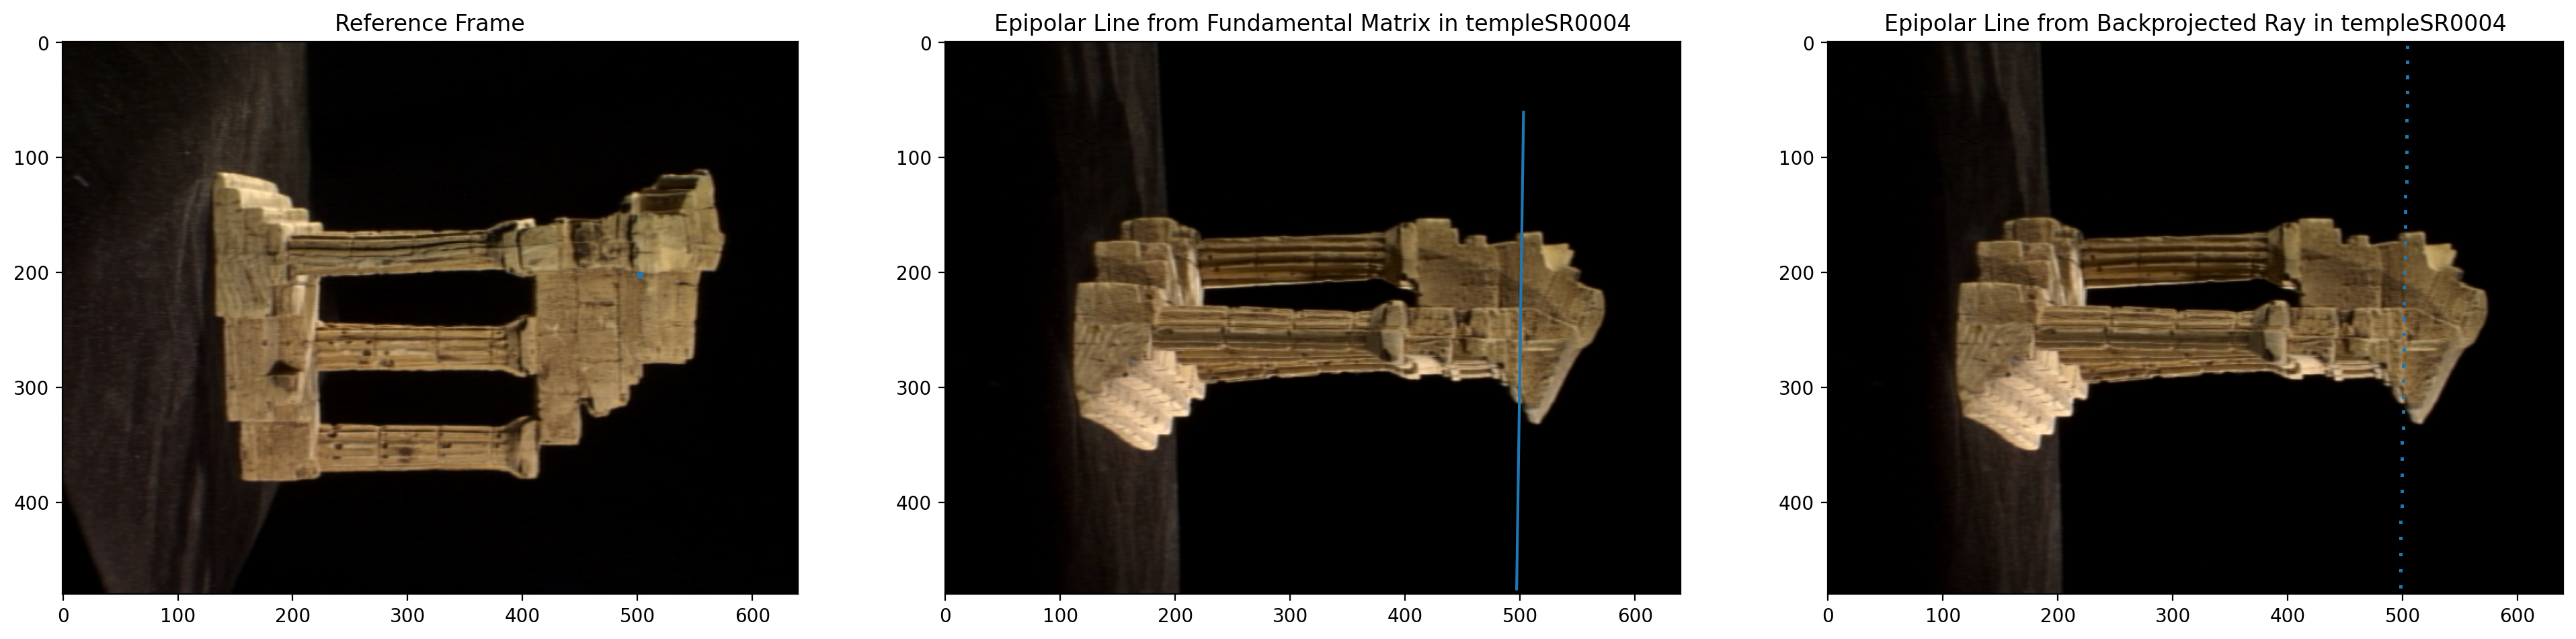

In [22]:
intrinsics, extrinsics = process_parameters()
shifted_extrinsics = set_reference(extrinsics)
fundamental = compute_fundamental_matrix(intrinsics, shifted_extrinsics, i=image_frame)
visualize_epipolar_line(pixel, intrinsics, shifted_extrinsics, fundamental, i=image_frame)

# Convert Notebook to PDF

[Alternative if the cell below doesn't work.](https://docs.google.com/document/d/1QTutnoApRow8cOxNrKK6ISEkA72QGfwLFXbIcpvarAI/edit?usp=sharing)

In [23]:
import os
from google.colab import drive
from google.colab import files

drive_mount_point = '/content/drive/'
drive.mount(drive_mount_point)

Mounted at /content/drive/


In [27]:
# generate pdf
# Please provide the full path of the notebook file below
# Important: make sure that your file name does not contain spaces!

# Ex: notebookpath = '/content/drive/My Drive/Colab Notebooks/EECS_442_PS4_FA_2022_Starter_Code.ipynb'
notebookpath = '/content/drive/My Drive/Colab Notebooks/PS10_javiersc.ipynb' 

file_name = notebookpath.split('/')[-1]
get_ipython().system("apt update && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended")
get_ipython().system("jupyter nbconvert --to PDF {}".format(notebookpath.replace(' ', '\\ ')))
files.download(notebookpath.split('.')[0]+'.pdf')

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Reading package lists... Done
Building dependency tree       
Reading state infor

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>